# Insgesamt Accidents Analysis and Modeling

In this notebook, I proposed a solution for forecasting the 'Insgesamt' category from Verkehrsunfälle accidents type in Munich accidents dataset. In this dataset, there are 4 categories of accidents.

In [1]:
import warnings
warnings.filterwarnings('ignore')

#Preparing, cleaning, analyzing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 
seed_number = 42
np.random.seed(seed_number)
tf.random.set_seed(seed_number)

## Data Preparation

In [2]:
df = pd.read_csv('clean_munic_accidents.csv', index_col='date')

In [3]:
df.head()

,category,accident_type,year,month,value
date,,,,,
2000-01-01,Fluchtunfälle,Verletzte und Getötete,2000,1,34
2000-01-01,Verkehrsunfälle,mit Personenschäden,2000,1,321
2000-01-01,Alkoholunfälle,insgesamt,2000,1,78
2000-01-01,Fluchtunfälle,insgesamt,2000,1,835
2000-01-01,Verkehrsunfälle,insgesamt,2000,1,3448


In [4]:
#Extracting the Alkoholunfälle
df = df[df.category == 'Alkoholunfälle']

In [5]:
#Extracting the insgesamt data

df = df[df.accident_type == 'insgesamt']

## Data Assesment

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2000-01-01 to 2020-12-01
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category       252 non-null    object
 1   accident_type  252 non-null    object
 2   year           252 non-null    int64 
 3   month          252 non-null    int64 
 4   value          252 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 11.8+ KB


In [7]:
df.head(15)

,category,accident_type,year,month,value
date,,,,,
2000-01-01,Alkoholunfälle,insgesamt,2000,1,78
2000-02-01,Alkoholunfälle,insgesamt,2000,2,53
2000-03-01,Alkoholunfälle,insgesamt,2000,3,73
2000-04-01,Alkoholunfälle,insgesamt,2000,4,78
2000-05-01,Alkoholunfälle,insgesamt,2000,5,96
2000-06-01,Alkoholunfälle,insgesamt,2000,6,57
2000-07-01,Alkoholunfälle,insgesamt,2000,7,99
2000-08-01,Alkoholunfälle,insgesamt,2000,8,77
2000-09-01,Alkoholunfälle,insgesamt,2000,9,84


In [8]:
df.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Here, All the values are proper Numbers except the 1st value

In [9]:
df.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)

Year column has incorrect datatype

In [10]:

df.accident_type.unique()

array(['insgesamt'], dtype=object)

## Cleaning
From above analysis I decided the follwoing:
- Remove accident_type, category
- Sort the values to have a sorted values according to the date column.

### Remove accident_type, category

In [11]:
df.drop(columns=['accident_type', 'category'], inplace=True, axis=1)

### Sorting values accordiing to the date

In [12]:
df.sort_values(['date'], inplace=True, ascending=True)

## Analyzing Data

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2000-01-01 to 2020-12-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    252 non-null    int64
 1   month   252 non-null    int64
 2   value   252 non-null    int64
dtypes: int64(3)
memory usage: 7.9+ KB


In [14]:
df.head()

,year,month,value
date,,,
2000-01-01,2000,1,78
2000-02-01,2000,2,53
2000-03-01,2000,3,73
2000-04-01,2000,4,78
2000-05-01,2000,5,96


Text(0.5, 1.0, 'Accidents per year')

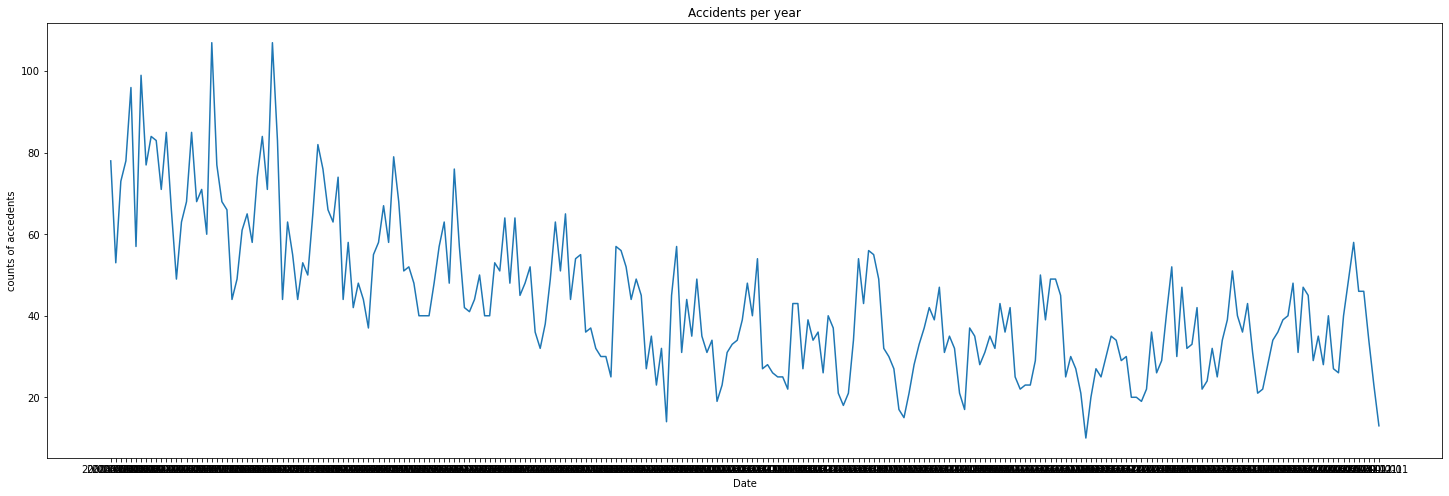

In [15]:
plt.figure(figsize=(25,8))
plt.plot( df.groupby(by =['date'])['value'].sum())
plt.xlabel('Date')
plt.ylabel('counts of accedents')
plt.title('Accidents per year')


In [16]:
acc_coun_per_month = [i for i in df.groupby(df.month)['value'].sum()]

Text(0.5, 1.0, 'Accidents per months from 2000 to 2020')

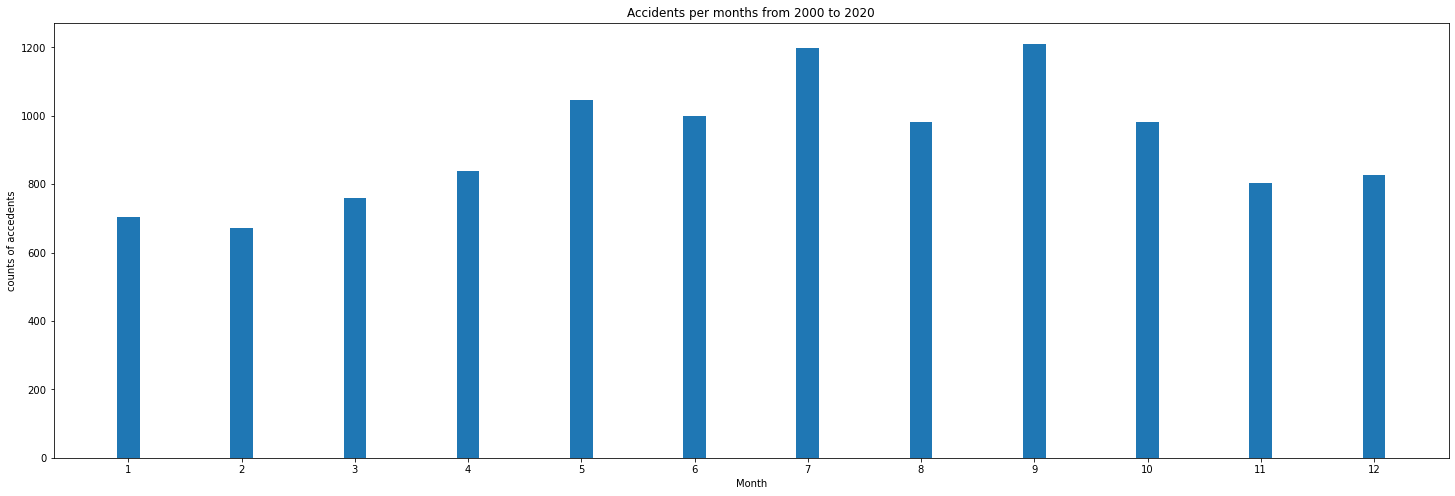

In [17]:
plt.figure(figsize=(25,8))
plt.xticks(range(len(df.month)), df.month)
width = 0.2
plt.bar(np.arange(len(acc_coun_per_month)), acc_coun_per_month, width=width)

plt.xlabel('Month')
plt.ylabel('counts of accedents')
plt.title('Accidents per months from 2000 to 2020')




We notice July month has the highest number of accidents and the least month is Jan

## Preprocessing

- Splitting Data into training and testing.
- Data Normalization.
- Preparing LSTM subsequences

### Splitting Data into training and testing

In [18]:
df

,year,month,value
date,,,
2000-01-01,2000,1,78
2000-02-01,2000,2,53
2000-03-01,2000,3,73
2000-04-01,2000,4,78
2000-05-01,2000,5,96
...,...,...,...
2020-08-01,2020,8,46
2020-09-01,2020,9,46
2020-10-01,2020,10,34


In [19]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
train, test = train_test_split(df, test_size=0.1, shuffle = False)



In [20]:
train[0:20]

,year,month,value
date,,,
2000-01-01,2000,1,78
2000-02-01,2000,2,53
2000-03-01,2000,3,73
2000-04-01,2000,4,78
2000-05-01,2000,5,96
2000-06-01,2000,6,57
2000-07-01,2000,7,99
2000-08-01,2000,8,77
2000-09-01,2000,9,84


In [21]:
test.head()

,year,month,value
date,,,
2018-11-01,2018,11,31
2018-12-01,2018,12,21
2019-01-01,2019,1,22
2019-02-01,2019,2,28
2019-03-01,2019,3,34


In [22]:
train.shape, test.shape

((226, 3), (26, 3))

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 2000-01-01 to 2018-10-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    226 non-null    int64
 1   month   226 non-null    int64
 2   value   226 non-null    int64
dtypes: int64(3)
memory usage: 7.1+ KB


### Data Normalization

In [24]:
f_scaler = RobustScaler()
cnt_scaler = RobustScaler()

#Features columns
f_columns = ['year', 'month']


# Fit the training
f_transformer = f_scaler.fit(train[f_columns].to_numpy())

#Transform the training
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())




cnt__transformer = cnt_scaler.fit(train[['value']])
#For output column
train['value'] = cnt__transformer.transform(train[['value']])
test['value'] = cnt__transformer.transform(test[['value']])


### Preparing LSTM subsequences

In [25]:
def creat_ds(x,y, time_step=1):
    #Create x series and y series to hold sequences
    xs, ys = [], []
    
    for i in range(len(x) - time_step):
        #Extract the sequence
        v = x.iloc[i: (i+time_step)].to_numpy()
        #append it into x series
        xs.append(v)
        
        #Repeat all above for y series
        ys.append(y.iloc[i+time_step])
    return np.array(xs), np.array(ys)   
    

In [26]:
#I will use the previous 5 months data to know the future data
#['category', 'accident_type', 'year', 'month']
Time_Step = 12
xs_train, ys_train = creat_ds(train, train.value, time_step=Time_Step)


xs_test, ys_test = creat_ds(test, test.value, time_step=Time_Step)

In [27]:
xs_train.shape, xs_test.shape

((214, 12, 3), (14, 12, 3))

In [28]:
ys_train.shape, ys_test.shape 

((214,), (14,))

In [29]:
xs_train.shape[1],xs_train.shape[2] 

(12, 3)

In [30]:
xs_train[0]

array([[-0.9       , -0.86956522,  1.5       ],
       [-0.9       , -0.69565217,  0.45833333],
       [-0.9       , -0.52173913,  1.29166667],
       [-0.9       , -0.34782609,  1.5       ],
       [-0.9       , -0.17391304,  2.25      ],
       [-0.9       ,  0.        ,  0.625     ],
       [-0.9       ,  0.17391304,  2.375     ],
       [-0.9       ,  0.34782609,  1.45833333],
       [-0.9       ,  0.52173913,  1.75      ],
       [-0.9       ,  0.69565217,  1.70833333],
       [-0.9       ,  0.86956522,  1.20833333],
       [-0.9       ,  1.04347826,  1.79166667]])

In [31]:
xs_train[1]

array([[-0.9       , -0.69565217,  0.45833333],
       [-0.9       , -0.52173913,  1.29166667],
       [-0.9       , -0.34782609,  1.5       ],
       [-0.9       , -0.17391304,  2.25      ],
       [-0.9       ,  0.        ,  0.625     ],
       [-0.9       ,  0.17391304,  2.375     ],
       [-0.9       ,  0.34782609,  1.45833333],
       [-0.9       ,  0.52173913,  1.75      ],
       [-0.9       ,  0.69565217,  1.70833333],
       [-0.9       ,  0.86956522,  1.20833333],
       [-0.9       ,  1.04347826,  1.79166667],
       [-0.8       , -0.86956522,  1.        ]])

In [32]:
ys_train[0]

1.0

## Modeling

In [33]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_copy_model.h5', monitor='val_loss', mode='min', verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

model = keras.Sequential()
model.add(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(64,input_shape = (xs_train.shape[1], xs_train.shape[2]))))

model.add(tf.keras.layers.Dense(units=1))

In [34]:
model.compile(loss = 'mse', optimizer=keras.optimizers.Adam(0.00001))

In [35]:
history = model.fit(xs_train, ys_train, epochs=10000, batch_size=4, validation_split=0.25,
                    shuffle=False, callbacks=[mc, es])

Epoch 1/10000
40/40 [==============================] - 2s 24ms/step - loss: 0.7121 - val_loss: 0.4654

Epoch 00001: saving model to best_copy_model.h5
Epoch 2/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.7000 - val_loss: 0.4574

Epoch 00002: saving model to best_copy_model.h5
Epoch 3/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.6880 - val_loss: 0.4491

Epoch 00003: saving model to best_copy_model.h5
Epoch 4/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.6757 - val_loss: 0.4408

Epoch 00004: saving model to best_copy_model.h5
Epoch 5/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.6635 - val_loss: 0.4326

Epoch 00005: saving model to best_copy_model.h5
Epoch 6/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.6513 - val_loss: 0.4246

Epoch 00006: saving model to best_copy_model.h5
Epoch 7/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.6393 - val_loss:

40/40 [==============================] - 1s 21ms/step - loss: 0.2892 - val_loss: 0.1863

Epoch 00055: saving model to best_copy_model.h5
Epoch 56/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.2868 - val_loss: 0.1844

Epoch 00056: saving model to best_copy_model.h5
Epoch 57/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.2845 - val_loss: 0.1826

Epoch 00057: saving model to best_copy_model.h5
Epoch 58/10000
40/40 [==============================] - ETA: 0s - loss: 0.295 - 1s 18ms/step - loss: 0.2824 - val_loss: 0.1808

Epoch 00058: saving model to best_copy_model.h5
Epoch 59/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.2804 - val_loss: 0.1792

Epoch 00059: saving model to best_copy_model.h5
Epoch 60/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.2785 - val_loss: 0.1776

Epoch 00060: saving model to best_copy_model.h5
Epoch 61/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.

40/40 [==============================] - 1s 21ms/step - loss: 0.2223 - val_loss: 0.1397

Epoch 00109: saving model to best_copy_model.h5
Epoch 110/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.2214 - val_loss: 0.1393

Epoch 00110: saving model to best_copy_model.h5
Epoch 111/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.2205 - val_loss: 0.1390

Epoch 00111: saving model to best_copy_model.h5
Epoch 112/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.2196 - val_loss: 0.1386

Epoch 00112: saving model to best_copy_model.h5
Epoch 113/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.2187 - val_loss: 0.1382

Epoch 00113: saving model to best_copy_model.h5
Epoch 114/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.2178 - val_loss: 0.1379

Epoch 00114: saving model to best_copy_model.h5
Epoch 115/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.2169 - val_loss: 0

40/40 [==============================] - 1s 20ms/step - loss: 0.1778 - val_loss: 0.1268

Epoch 00162: saving model to best_copy_model.h5
Epoch 163/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1770 - val_loss: 0.1266

Epoch 00163: saving model to best_copy_model.h5
Epoch 164/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1762 - val_loss: 0.1264

Epoch 00164: saving model to best_copy_model.h5
Epoch 165/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1755 - val_loss: 0.1263

Epoch 00165: saving model to best_copy_model.h5
Epoch 166/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1747 - val_loss: 0.1261

Epoch 00166: saving model to best_copy_model.h5
Epoch 167/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1740 - val_loss: 0.1259

Epoch 00167: saving model to best_copy_model.h5
Epoch 168/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1732 - val_loss: 0

40/40 [==============================] - 1s 27ms/step - loss: 0.1440 - val_loss: 0.1184

Epoch 00215: saving model to best_copy_model.h5
Epoch 216/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1435 - val_loss: 0.1183

Epoch 00216: saving model to best_copy_model.h5
Epoch 217/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1431 - val_loss: 0.1181

Epoch 00217: saving model to best_copy_model.h5
Epoch 218/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1426 - val_loss: 0.1180

Epoch 00218: saving model to best_copy_model.h5
Epoch 219/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1422 - val_loss: 0.1178

Epoch 00219: saving model to best_copy_model.h5
Epoch 220/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1418 - val_loss: 0.1177

Epoch 00220: saving model to best_copy_model.h5
Epoch 221/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1414 - val_loss: 0

40/40 [==============================] - 1s 21ms/step - loss: 0.1305 - val_loss: 0.1114

Epoch 00268: saving model to best_copy_model.h5
Epoch 269/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1304 - val_loss: 0.1113

Epoch 00269: saving model to best_copy_model.h5
Epoch 270/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1303 - val_loss: 0.1112

Epoch 00270: saving model to best_copy_model.h5
Epoch 271/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1302 - val_loss: 0.1111

Epoch 00271: saving model to best_copy_model.h5
Epoch 272/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1301 - val_loss: 0.1110

Epoch 00272: saving model to best_copy_model.h5
Epoch 273/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1300 - val_loss: 0.1109

Epoch 00273: saving model to best_copy_model.h5
Epoch 274/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1299 - val_loss: 0

40/40 [==============================] - 1s 21ms/step - loss: 0.1276 - val_loss: 0.1065

Epoch 00321: saving model to best_copy_model.h5
Epoch 322/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1275 - val_loss: 0.1064

Epoch 00322: saving model to best_copy_model.h5
Epoch 323/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1275 - val_loss: 0.1064

Epoch 00323: saving model to best_copy_model.h5
Epoch 324/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1275 - val_loss: 0.1063

Epoch 00324: saving model to best_copy_model.h5
Epoch 325/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1275 - val_loss: 0.1062

Epoch 00325: saving model to best_copy_model.h5
Epoch 326/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1274 - val_loss: 0.1061

Epoch 00326: saving model to best_copy_model.h5
Epoch 327/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1274 - val_loss: 0

40/40 [==============================] - 1s 21ms/step - loss: 0.1265 - val_loss: 0.1032

Epoch 00374: saving model to best_copy_model.h5
Epoch 375/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1264 - val_loss: 0.1032

Epoch 00375: saving model to best_copy_model.h5
Epoch 376/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1264 - val_loss: 0.1031

Epoch 00376: saving model to best_copy_model.h5
Epoch 377/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1264 - val_loss: 0.1031

Epoch 00377: saving model to best_copy_model.h5
Epoch 378/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1264 - val_loss: 0.1030

Epoch 00378: saving model to best_copy_model.h5
Epoch 379/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1264 - val_loss: 0.1030

Epoch 00379: saving model to best_copy_model.h5
Epoch 380/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1264 - val_loss: 0


Epoch 00427: saving model to best_copy_model.h5
Epoch 428/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1256 - val_loss: 0.1012

Epoch 00428: saving model to best_copy_model.h5
Epoch 429/10000
40/40 [==============================] - 1s 18ms/step - loss: 0.1256 - val_loss: 0.1011

Epoch 00429: saving model to best_copy_model.h5
Epoch 430/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1256 - val_loss: 0.1011

Epoch 00430: saving model to best_copy_model.h5
Epoch 431/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1256 - val_loss: 0.1011

Epoch 00431: saving model to best_copy_model.h5
Epoch 432/10000
40/40 [==============================] - 1s 18ms/step - loss: 0.1256 - val_loss: 0.1011

Epoch 00432: saving model to best_copy_model.h5
Epoch 433/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1256 - val_loss: 0.1010

Epoch 00433: saving model to best_copy_model.h5
Epoch 434/10000
40/40 [==========

40/40 [==============================] - 1s 20ms/step - loss: 0.1249 - val_loss: 0.0999

Epoch 00481: saving model to best_copy_model.h5
Epoch 482/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1249 - val_loss: 0.0999

Epoch 00482: saving model to best_copy_model.h5
Epoch 483/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1249 - val_loss: 0.0999

Epoch 00483: saving model to best_copy_model.h5
Epoch 484/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1249 - val_loss: 0.0999

Epoch 00484: saving model to best_copy_model.h5
Epoch 485/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1249 - val_loss: 0.0999

Epoch 00485: saving model to best_copy_model.h5
Epoch 486/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1249 - val_loss: 0.0998

Epoch 00486: saving model to best_copy_model.h5
Epoch 487/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1249 - val_loss: 0


Epoch 00534: saving model to best_copy_model.h5
Epoch 535/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1243 - val_loss: 0.0991

Epoch 00535: saving model to best_copy_model.h5
Epoch 536/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1243 - val_loss: 0.0991

Epoch 00536: saving model to best_copy_model.h5
Epoch 537/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1243 - val_loss: 0.0991

Epoch 00537: saving model to best_copy_model.h5
Epoch 538/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1243 - val_loss: 0.0990

Epoch 00538: saving model to best_copy_model.h5
Epoch 539/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1243 - val_loss: 0.0990

Epoch 00539: saving model to best_copy_model.h5
Epoch 540/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1242 - val_loss: 0.0990

Epoch 00540: saving model to best_copy_model.h5
Epoch 541/10000
40/40 [==========

40/40 [==============================] - 1s 19ms/step - loss: 0.1237 - val_loss: 0.0985

Epoch 00588: saving model to best_copy_model.h5
Epoch 589/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1237 - val_loss: 0.0985

Epoch 00589: saving model to best_copy_model.h5
Epoch 590/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1237 - val_loss: 0.0985

Epoch 00590: saving model to best_copy_model.h5
Epoch 591/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1237 - val_loss: 0.0985

Epoch 00591: saving model to best_copy_model.h5
Epoch 592/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1237 - val_loss: 0.0984

Epoch 00592: saving model to best_copy_model.h5
Epoch 593/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1237 - val_loss: 0.0984

Epoch 00593: saving model to best_copy_model.h5
Epoch 594/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1236 - val_loss: 0

40/40 [==============================] - 1s 19ms/step - loss: 0.1232 - val_loss: 0.0980

Epoch 00641: saving model to best_copy_model.h5
Epoch 642/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1231 - val_loss: 0.0980

Epoch 00642: saving model to best_copy_model.h5
Epoch 643/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1231 - val_loss: 0.0980

Epoch 00643: saving model to best_copy_model.h5
Epoch 644/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1231 - val_loss: 0.0980

Epoch 00644: saving model to best_copy_model.h5
Epoch 645/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1231 - val_loss: 0.0980

Epoch 00645: saving model to best_copy_model.h5
Epoch 646/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1231 - val_loss: 0.0980

Epoch 00646: saving model to best_copy_model.h5
Epoch 647/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1231 - val_loss: 0


Epoch 00694: saving model to best_copy_model.h5
Epoch 695/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00695: saving model to best_copy_model.h5
Epoch 696/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00696: saving model to best_copy_model.h5
Epoch 697/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00697: saving model to best_copy_model.h5
Epoch 698/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00698: saving model to best_copy_model.h5
Epoch 699/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00699: saving model to best_copy_model.h5
Epoch 700/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00700: saving model to best_copy_model.h5
Epoch 701/10000
40/40 [==========

40/40 [==============================] - 1s 20ms/step - loss: 0.1221 - val_loss: 0.0973

Epoch 00748: saving model to best_copy_model.h5
Epoch 749/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1221 - val_loss: 0.0973

Epoch 00749: saving model to best_copy_model.h5
Epoch 750/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1221 - val_loss: 0.0973

Epoch 00750: saving model to best_copy_model.h5
Epoch 751/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1221 - val_loss: 0.0972

Epoch 00751: saving model to best_copy_model.h5
Epoch 752/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1221 - val_loss: 0.0972

Epoch 00752: saving model to best_copy_model.h5
Epoch 753/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1221 - val_loss: 0.0972

Epoch 00753: saving model to best_copy_model.h5
Epoch 754/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1221 - val_loss: 0


Epoch 00801: saving model to best_copy_model.h5
Epoch 802/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1217 - val_loss: 0.0970

Epoch 00802: saving model to best_copy_model.h5
Epoch 803/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00803: saving model to best_copy_model.h5
Epoch 804/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00804: saving model to best_copy_model.h5
Epoch 805/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00805: saving model to best_copy_model.h5
Epoch 806/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00806: saving model to best_copy_model.h5
Epoch 807/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00807: saving model to best_copy_model.h5
Epoch 808/10000
40/40 [==========

40/40 [==============================] - 1s 20ms/step - loss: 0.1212 - val_loss: 0.0967

Epoch 00855: saving model to best_copy_model.h5
Epoch 856/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1212 - val_loss: 0.0967

Epoch 00856: saving model to best_copy_model.h5
Epoch 857/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1212 - val_loss: 0.0967

Epoch 00857: saving model to best_copy_model.h5
Epoch 858/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1212 - val_loss: 0.0967

Epoch 00858: saving model to best_copy_model.h5
Epoch 859/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1212 - val_loss: 0.0966

Epoch 00859: saving model to best_copy_model.h5
Epoch 860/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1212 - val_loss: 0.0966

Epoch 00860: saving model to best_copy_model.h5
Epoch 861/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1212 - val_loss: 0

40/40 [==============================] - 1s 21ms/step - loss: 0.1208 - val_loss: 0.0964

Epoch 00908: saving model to best_copy_model.h5
Epoch 909/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1208 - val_loss: 0.0964

Epoch 00909: saving model to best_copy_model.h5
Epoch 910/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1208 - val_loss: 0.0964

Epoch 00910: saving model to best_copy_model.h5
Epoch 911/10000
40/40 [==============================] - 1s 18ms/step - loss: 0.1208 - val_loss: 0.0964

Epoch 00911: saving model to best_copy_model.h5
Epoch 912/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1207 - val_loss: 0.0964

Epoch 00912: saving model to best_copy_model.h5
Epoch 913/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1207 - val_loss: 0.0964

Epoch 00913: saving model to best_copy_model.h5
Epoch 914/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1207 - val_loss: 0


Epoch 00961: saving model to best_copy_model.h5
Epoch 962/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 00962: saving model to best_copy_model.h5
Epoch 963/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1203 - val_loss: 0.0961

Epoch 00963: saving model to best_copy_model.h5
Epoch 964/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0961

Epoch 00964: saving model to best_copy_model.h5
Epoch 965/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1203 - val_loss: 0.0961

Epoch 00965: saving model to best_copy_model.h5
Epoch 966/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1203 - val_loss: 0.0961

Epoch 00966: saving model to best_copy_model.h5
Epoch 967/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1203 - val_loss: 0.0961

Epoch 00967: saving model to best_copy_model.h5
Epoch 968/10000
40/40 [==========

40/40 [==============================] - 1s 20ms/step - loss: 0.1200 - val_loss: 0.0959

Epoch 01015: saving model to best_copy_model.h5
Epoch 1016/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01016: saving model to best_copy_model.h5
Epoch 1017/10000
40/40 [==============================] - 1s 18ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01017: saving model to best_copy_model.h5
Epoch 1018/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01018: saving model to best_copy_model.h5
Epoch 1019/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01019: saving model to best_copy_model.h5
Epoch 1020/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01020: saving model to best_copy_model.h5
Epoch 1021/10000
40/40 [==============================] - 1s 18ms/step - loss: 0.1199 - val_l

40/40 [==============================] - 1s 19ms/step - loss: 0.1196 - val_loss: 0.0957

Epoch 01068: saving model to best_copy_model.h5
Epoch 1069/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1196 - val_loss: 0.0957

Epoch 01069: saving model to best_copy_model.h5
Epoch 1070/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1196 - val_loss: 0.0957

Epoch 01070: saving model to best_copy_model.h5
Epoch 1071/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1195 - val_loss: 0.0957

Epoch 01071: saving model to best_copy_model.h5
Epoch 1072/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1195 - val_loss: 0.0957

Epoch 01072: saving model to best_copy_model.h5
Epoch 1073/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1195 - val_loss: 0.0957

Epoch 01073: saving model to best_copy_model.h5
Epoch 1074/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1195 - val_l

40/40 [==============================] - 1s 20ms/step - loss: 0.1192 - val_loss: 0.0955

Epoch 01121: saving model to best_copy_model.h5
Epoch 1122/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1192 - val_loss: 0.0955

Epoch 01122: saving model to best_copy_model.h5
Epoch 1123/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1192 - val_loss: 0.0955

Epoch 01123: saving model to best_copy_model.h5
Epoch 1124/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1192 - val_loss: 0.0955

Epoch 01124: saving model to best_copy_model.h5
Epoch 1125/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1192 - val_loss: 0.0955

Epoch 01125: saving model to best_copy_model.h5
Epoch 1126/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1192 - val_loss: 0.0954

Epoch 01126: saving model to best_copy_model.h5
Epoch 1127/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1192 - val_l

40/40 [==============================] - 1s 21ms/step - loss: 0.1188 - val_loss: 0.0953

Epoch 01174: saving model to best_copy_model.h5
Epoch 1175/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1188 - val_loss: 0.0953

Epoch 01175: saving model to best_copy_model.h5
Epoch 1176/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1188 - val_loss: 0.0953

Epoch 01176: saving model to best_copy_model.h5
Epoch 1177/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1188 - val_loss: 0.0953

Epoch 01177: saving model to best_copy_model.h5
Epoch 1178/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1188 - val_loss: 0.0953

Epoch 01178: saving model to best_copy_model.h5
Epoch 1179/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1188 - val_loss: 0.0953

Epoch 01179: saving model to best_copy_model.h5
Epoch 1180/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1188 - val_l

40/40 [==============================] - 1s 29ms/step - loss: 0.1185 - val_loss: 0.0951

Epoch 01227: saving model to best_copy_model.h5
Epoch 1228/10000
40/40 [==============================] - 1s 29ms/step - loss: 0.1185 - val_loss: 0.0951

Epoch 01228: saving model to best_copy_model.h5
Epoch 1229/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1185 - val_loss: 0.0951

Epoch 01229: saving model to best_copy_model.h5
Epoch 1230/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1185 - val_loss: 0.0951

Epoch 01230: saving model to best_copy_model.h5
Epoch 1231/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1184 - val_loss: 0.0951

Epoch 01231: saving model to best_copy_model.h5
Epoch 1232/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1184 - val_loss: 0.0951

Epoch 01232: saving model to best_copy_model.h5
Epoch 1233/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1184 - val_l

40/40 [==============================] - 1s 21ms/step - loss: 0.1181 - val_loss: 0.0949

Epoch 01280: saving model to best_copy_model.h5
Epoch 1281/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1181 - val_loss: 0.0949

Epoch 01281: saving model to best_copy_model.h5
Epoch 1282/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1181 - val_loss: 0.0949

Epoch 01282: saving model to best_copy_model.h5
Epoch 1283/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1181 - val_loss: 0.0949

Epoch 01283: saving model to best_copy_model.h5
Epoch 1284/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1181 - val_loss: 0.0949

Epoch 01284: saving model to best_copy_model.h5
Epoch 1285/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1181 - val_loss: 0.0949

Epoch 01285: saving model to best_copy_model.h5
Epoch 1286/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1181 - val_l

40/40 [==============================] - 1s 21ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01333: saving model to best_copy_model.h5
Epoch 1334/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01334: saving model to best_copy_model.h5
Epoch 1335/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01335: saving model to best_copy_model.h5
Epoch 1336/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01336: saving model to best_copy_model.h5
Epoch 1337/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01337: saving model to best_copy_model.h5
Epoch 1338/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01338: saving model to best_copy_model.h5
Epoch 1339/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1178 - val_l

40/40 [==============================] - 1s 22ms/step - loss: 0.1175 - val_loss: 0.0946

Epoch 01386: saving model to best_copy_model.h5
Epoch 1387/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1175 - val_loss: 0.0946

Epoch 01387: saving model to best_copy_model.h5
Epoch 1388/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1174 - val_loss: 0.0946

Epoch 01388: saving model to best_copy_model.h5
Epoch 1389/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1174 - val_loss: 0.0946

Epoch 01389: saving model to best_copy_model.h5
Epoch 1390/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1174 - val_loss: 0.0946

Epoch 01390: saving model to best_copy_model.h5
Epoch 1391/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1174 - val_loss: 0.0946

Epoch 01391: saving model to best_copy_model.h5
Epoch 1392/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1174 - val_l

40/40 [==============================] - 1s 20ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01439: saving model to best_copy_model.h5
Epoch 1440/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01440: saving model to best_copy_model.h5
Epoch 1441/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01441: saving model to best_copy_model.h5
Epoch 1442/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01442: saving model to best_copy_model.h5
Epoch 1443/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01443: saving model to best_copy_model.h5
Epoch 1444/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01444: saving model to best_copy_model.h5
Epoch 1445/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1171 - val_l

40/40 [==============================] - 1s 27ms/step - loss: 0.1168 - val_loss: 0.0944

Epoch 01492: saving model to best_copy_model.h5
Epoch 1493/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1168 - val_loss: 0.0944

Epoch 01493: saving model to best_copy_model.h5
Epoch 1494/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1168 - val_loss: 0.0944

Epoch 01494: saving model to best_copy_model.h5
Epoch 1495/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1168 - val_loss: 0.0943

Epoch 01495: saving model to best_copy_model.h5
Epoch 1496/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1168 - val_loss: 0.0943

Epoch 01496: saving model to best_copy_model.h5
Epoch 1497/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1168 - val_loss: 0.0943

Epoch 01497: saving model to best_copy_model.h5
Epoch 1498/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1168 - val_l

40/40 [==============================] - 1s 22ms/step - loss: 0.1165 - val_loss: 0.0943

Epoch 01545: saving model to best_copy_model.h5
Epoch 1546/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1165 - val_loss: 0.0943

Epoch 01546: saving model to best_copy_model.h5
Epoch 1547/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1165 - val_loss: 0.0943

Epoch 01547: saving model to best_copy_model.h5
Epoch 1548/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1165 - val_loss: 0.0943

Epoch 01548: saving model to best_copy_model.h5
Epoch 1549/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1165 - val_loss: 0.0942

Epoch 01549: saving model to best_copy_model.h5
Epoch 1550/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1165 - val_loss: 0.0942

Epoch 01550: saving model to best_copy_model.h5
Epoch 1551/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1165 - val_l

40/40 [==============================] - 1s 23ms/step - loss: 0.1162 - val_loss: 0.0942

Epoch 01598: saving model to best_copy_model.h5
Epoch 1599/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1162 - val_loss: 0.0942

Epoch 01599: saving model to best_copy_model.h5
Epoch 1600/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1162 - val_loss: 0.0942

Epoch 01600: saving model to best_copy_model.h5
Epoch 1601/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1162 - val_loss: 0.0942

Epoch 01601: saving model to best_copy_model.h5
Epoch 1602/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1162 - val_loss: 0.0942

Epoch 01602: saving model to best_copy_model.h5
Epoch 1603/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1162 - val_loss: 0.0942

Epoch 01603: saving model to best_copy_model.h5
Epoch 1604/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1162 - val_l

40/40 [==============================] - 1s 23ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01651: saving model to best_copy_model.h5
Epoch 1652/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01652: saving model to best_copy_model.h5
Epoch 1653/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01653: saving model to best_copy_model.h5
Epoch 1654/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01654: saving model to best_copy_model.h5
Epoch 1655/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01655: saving model to best_copy_model.h5
Epoch 1656/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01656: saving model to best_copy_model.h5
Epoch 1657/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1159 - val_l

40/40 [==============================] - 1s 20ms/step - loss: 0.1156 - val_loss: 0.0941

Epoch 01704: saving model to best_copy_model.h5
Epoch 1705/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1156 - val_loss: 0.0941

Epoch 01705: saving model to best_copy_model.h5
Epoch 1706/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1156 - val_loss: 0.0941

Epoch 01706: saving model to best_copy_model.h5
Epoch 1707/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1156 - val_loss: 0.0941

Epoch 01707: saving model to best_copy_model.h5
Epoch 1708/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1156 - val_loss: 0.0941

Epoch 01708: saving model to best_copy_model.h5
Epoch 1709/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1156 - val_loss: 0.0941

Epoch 01709: saving model to best_copy_model.h5
Epoch 1710/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1156 - val_l

40/40 [==============================] - 1s 20ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01757: saving model to best_copy_model.h5
Epoch 1758/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01758: saving model to best_copy_model.h5
Epoch 1759/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01759: saving model to best_copy_model.h5
Epoch 1760/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01760: saving model to best_copy_model.h5
Epoch 1761/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01761: saving model to best_copy_model.h5
Epoch 1762/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01762: saving model to best_copy_model.h5
Epoch 1763/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1153 - val_l

40/40 [==============================] - 1s 20ms/step - loss: 0.1150 - val_loss: 0.0940

Epoch 01810: saving model to best_copy_model.h5
Epoch 1811/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1150 - val_loss: 0.0940

Epoch 01811: saving model to best_copy_model.h5
Epoch 1812/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1150 - val_loss: 0.0940

Epoch 01812: saving model to best_copy_model.h5
Epoch 1813/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1150 - val_loss: 0.0940

Epoch 01813: saving model to best_copy_model.h5
Epoch 1814/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1150 - val_loss: 0.0940

Epoch 01814: saving model to best_copy_model.h5
Epoch 1815/10000
40/40 [==============================] - ETA: 0s - loss: 0.117 - 1s 21ms/step - loss: 0.1150 - val_loss: 0.0940

Epoch 01815: saving model to best_copy_model.h5
Epoch 1816/10000
40/40 [==============================] - 1s 20ms/ste

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 64)                17408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


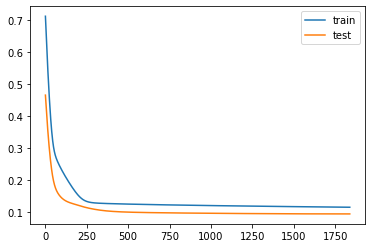

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [38]:
y_predict = model.predict(xs_test)

In [39]:
y_predict

array([[-0.66138035],
       [-0.88337904],
       [-1.0842513 ],
       [-1.0087978 ],
       [-0.8117906 ],
       [-0.6048166 ],
       [-0.40862593],
       [-0.26158935],
       [-0.20226048],
       [-0.23686452],
       [-0.346873  ],
       [-0.51605576],
       [-0.7281824 ],
       [-0.93921435]], dtype=float32)

In [40]:
y_train_inv = cnt__transformer.inverse_transform(ys_train.reshape(1, -1))
y_test_inv = cnt__transformer.inverse_transform(ys_test.reshape(1, -1))
y_pred_inv = cnt__transformer.inverse_transform(y_predict)

In [41]:
y_pred_inv

array([[26.126871],
       [20.798903],
       [15.97797 ],
       [17.788853],
       [22.517025],
       [27.484402],
       [32.192978],
       [35.721855],
       [37.14575 ],
       [36.31525 ],
       [33.67505 ],
       [29.614662],
       [24.523623],
       [19.458855]], dtype=float32)

In [42]:
y_test_inv

array([[29., 35., 28., 40., 27., 26., 40., 49., 58., 46., 46., 34., 23.,
        13.]])

## Inference

In [44]:
category= 'Alkoholunfälle'
type= 'insgesamt'
year= '2021'
month= '01'


In [45]:
def main():
    if category == 'Alkoholunfälle':
        
        if type == 'insgesamt':
            month_ls = [1,2,3,4,5,6,7,8,9,10,11,12,1]
            year_ls = [2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021]
            value_ls = list(df['value'][-12:])
            #print(value_ls)

            value_ls.append(0)
            #print()
            #print()
            inf_df = pd.DataFrame(list(zip(year_ls, month_ls, value_ls)), columns =['year', 'month', 'value'])
            #print(inf_df)
            xs_inf, ys_inf = creat_ds(inf_df, inf_df.value, time_step=Time_Step)
            #print()
            #print(xs_inf)
            #print()
            #print(ys_inf)
            y_predict_inf = model.predict(xs_inf)
            y_pred_inv = cnt__transformer.inverse_transform(y_predict_inf)
    print(y_pred_inv[0][0])         
          
                 
          

In [46]:
main()

13.006308


In [47]:
category= 'Alkoholunfälle'
type= 'insgesamt'
year= '2021'
month= '01'


def main():
    if category == 'Alkoholunfälle':
        
        if type == 'insgesamt':
            month_ls = [1,2,3,4,5,6,7,8,9,10,11,12,1]
            year_ls = [2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021]
            value_ls = list(df['value'][-12:])
            #print(value_ls)

            value_ls.append(0)
            #print()
            #print()
            inf_df = pd.DataFrame(list(zip(year_ls, month_ls, value_ls)), columns =['year', 'month', 'value'])
            #print(inf_df)
            xs_inf, ys_inf = creat_ds(inf_df, inf_df.value, time_step=Time_Step)
            #print()
            #print(xs_inf)
            #print()
            #print(ys_inf)
            y_predict_inf = model.predict(xs_inf)
            y_pred_inv = cnt__transformer.inverse_transform(y_predict_inf)
    print(y_pred_inv[0][0])         

In [48]:
main()

13.006308


- https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/
- https://www.youtube.com/watch?v=xaIA83x5Icg
- https://www.youtube.com/watch?v=uw6zYLbCGkY